In [702]:
import sys
import os
import io
import re
import db
import wrangling as wr
import numpy as np
import operator
import matplotlib.pyplot as plt; plt.rcdefaults()
import statsmodels.api as sm
from scipy import stats
import copy


# import plotly.plotly as py
# import plotly.graph_objs as go
# from __future__ import statistcs as stats

databaseName = "database.csv"
fundedProjectsFile = "FundedProjects.csv"
dbreaderHandle = db.createReader(databaseName)
fundedProjectsHandle = db.createReader(fundedProjectsFile)
dbreader = dbreaderHandle[0]
fprojectsreader = fundedProjectsHandle[0]

# vectors & dicts
locationLatAndLong = []

countiesDict = {}
fundedCountiesDict = {}

proposedProjectsSponsorsDict = {}
sponsorsOfProposedProjects = {}
sponsorsOfFundedProjects = {}

areasOfInterestByCounty = {}

projFundingAmounts =  []
projTotalCosts = []
fundedProjectsTitles = []

# Vectors used during classification.
proposedProjectsTitles = []
proposedProjectsAbstracts = []
proposedProjectsLocationDescriptions = []
proposedProjectsProjectTypeDescription = []
proposedProjectsDetailedDescription = []
proposedProjectsProjectNeed = []
proposedProjectsCriticalImpacts = []
proposedProjectsBenefits = []

essence = []

# Bitvectors
drinkingWater = []
waterQualityImprovement = []
waterReuseAndRecycling = []
stormwaterImprovements = []
groundwaterBenefits = []
infiltration = []
habitatProtection = []
floodProtection = []

bitVecList = [drinkingWater, waterQualityImprovement, waterReuseAndRecycling,stormwaterImprovements,
              groundwaterBenefits, infiltration, habitatProtection, floodProtection]

#Constants
areasOfInterest = [
    'Drinking Water Supply',
    'Water Quality Improvement',
    'Water Reuse/Recycling',
    'Stormwater Improvements',
    'Groundwater Benefits',
    'Infiltration',
    'Habitat Protection and Restoration',
    'Flood Protection'
]

kDistance = 0.0

In [703]:
def fillSponsorsDict(row):
    sponsorsStr = row[12]
    sponsorsStr = sponsorsStr.strip().replace("\n", "/")
    if len(sponsorsStr) == 0:
        return
    tokens = sponsorsStr.split("/")
    for eachAgency in tokens:
        eachAgency = eachAgency.strip()
        if len(sponsorsStr) == 0:
            continue
        if "zone 7" in sponsorsStr or sponsorsStr is "zone 7":
            sponsorsStr = "zone 7 water agency"
            
        if eachAgency in sponsorsOfProposedProjects:
            sponsorsOfProposedProjects[eachAgency] += 1
        else:
            sponsorsOfProposedProjects[eachAgency] = 1


In [704]:
def appendBitvectors(row):
    appendToV(row, drinkingWater, 13)
    appendToV(row, waterQualityImprovement, 14)
    appendToV(row, waterReuseAndRecycling, 15)
    appendToV(row, stormwaterImprovements, 16)
    appendToV(row, groundwaterBenefits, 17)
    appendToV(row, infiltration, 18)
    appendToV(row, habitatProtection, 19)
    appendToV(row, floodProtection, 20)
    
def appendToV(row, vector, index):
    if("1" in row[index]):
        vector.append(1)
    else:
        vector.append(0)

In [705]:
def incrementAreasOfInterestCounts(ls, row):
    start = 13
    end = 20         
    for i in range(start, end+1):
        if("1" in row[i]):
            ls[i - start] += 1

def initialize(row):
    ls = []
    start = 13
    end = 20
    for i in range(start, end+1):
        if("1" in row[i]):
            ls.append(1)
        else:
            ls.append(0)
    return ls


def appendCounties(row):
    countyStr = row[2]
    counties1 = []
    counties2 = []

    countyStr = countyStr.replace("and ", "").replace("and", "").replace("?", "").replace(".", "").replace("Counties","")
    counties1 = countyStr.replace("county", "").split(";")
    for name in counties1:
        name = name.strip();
        if "sf" in name or "francsico" in name:
            name = u"san francisco"
        if "mateo santa" in name:
            counties2.append(u"san mateo")
            counties2.append(u"santa clara")
            continue
        if "mateo san fr" in name:
            counties2.append(u"san mateo")
            counties2.append(u"san francisco")
            continue;
        if len(name) > 0 and "county" not in name and not (name.startswith("all") or name.startswith("9")):
            counties2.append(name)

    for eachName in counties2:
        if eachName:
            if eachName in countiesDict:
                countiesDict[eachName] += 1
            else:
                countiesDict[eachName] = 1
                 
            if eachName in areasOfInterestByCounty:
                incrementAreasOfInterestCounts(areasOfInterestByCounty[eachName], row)
            else:
                areasOfInterestByCounty[eachName] = initialize(row)
                
def compileProposedProjectsDicts(reader):
    for row in reader:
        if row[12]:
            if row[12] in proposedProjectsSponsorsDict:
                proposedProjectsSponsorsDict[row[12]] += 1
            else:
                proposedProjectsSponsorsDict[row[12]] = 1

In [706]:
def append(to,from_, at):
    to.append(from_[at])

def appendToClassificationVectors(row):
    append(proposedProjectsTitles, row, 0)
    append(proposedProjectsAbstracts, row, 1)
#     append(proposedProjectsLocationDescriptions, row, 6)
    append(proposedProjectsProjectTypeDescription, row, 7)
    append(proposedProjectsDetailedDescription, row, 8)
    append(proposedProjectsProjectNeed, row, 9)
    append(proposedProjectsCriticalImpacts, row, 10)
    append(proposedProjectsBenefits, row, 11)
    
    curEssence = row[0] + " " + row[1] + " " + row[6] + " " + row[7] + " " + row[8] + " " + row[9] + " "
    curEssence += row[10] + " " + row[11]
    remove_list = [
                "'s","s", "use", "reduce", "city","increase", "existing", "regional",
                "bay", "area", "storage", "improvements", "water", "management", "use", 
                "reduce", "this", "this", "project", "city", "district", "county", "provide", "town",
                "east", "south", "north", "west", "restore", "quality", "san francisco", "hed", "program",
                "plan", "system"]
    for each in remove_list:
        curEssence = curEssence.replace(each, "")
    essence.append(curEssence.strip())

In [707]:
# def readInFundingAmounts(row):
#     fundedProjectsTitles.append(row[0])
#     projFundingAmounts.append(row[6])
#     projTotalCosts.append(row[7])
 
def addToDict(dictName, name):
    if name in dictName:
        dictName[name] += 1
    else:
        dictName[name] = 1

def fillFundedCountiesDict(row):
    countyStr = row[3].strip().lower()
    if not countyStr:
        addToDict(fundedCountiesDict, "regional")
        return 
    countyStr = countyStr.replace(" and ", ";").replace("/", ";").replace(" +", "").strip()
    if "costa" not in countyStr and ";co" in countyStr:
        countyStr = "alameda;contra costa"   
    if "sanmateo" in countyStr:
        countyStr = countyStr.replace("sanmateo", "san mateo")
    if "sanfrancisco" in countyStr:
        countyStr = countyStr.replace("sanfrancisco", "san francisco")   
    counties = countyStr.split(";")
    for each in counties:
        addToDict(fundedCountiesDict, each)
        
def fillSponsorsDict_f(row):
    sponsorStr = row[1].lower().strip().replace("/", ";").replace("agencey", "agency")
    sponsors = sponsorStr.split(";")
    for each in sponsors:
        # Process It further
        each = each.strip()
        if each == "water district":
            continue
        addToDict(sponsorsOfFundedProjects, each)
    
    
        
def execute():
    next(fprojectsreader)
    for row in fprojectsreader:
        fillFundedCountiesDict(row)
        fillSponsorsDict_f(row) # funded projects
#     for each in sponsorsOfFundedProjects:
#         print each + " " + str(sponsorsOfFundedProjects[each])
#         readInFundingAmounts(row)
            
execute() 

In [708]:
def isArchivedProject(row):
    return row[2] == "" and row[3] == "" and row[4] == ""

def execute():
    next(dbreader) # Skip header
    for row in dbreader:
        appendCounties(row)
        appendBitvectors(row)
        fillSponsorsDict(row)
        if not isArchivedProject(row):
            appendToClassificationVectors(row)
        
def closeReaders():
    db.closeDB(dbreaderHandle[1])
    db.closeDB(fundedProjectsHandle[1])
    
execute()
# for k  in sponsorsOfProposedProjects:
#     print k
closeReaders()

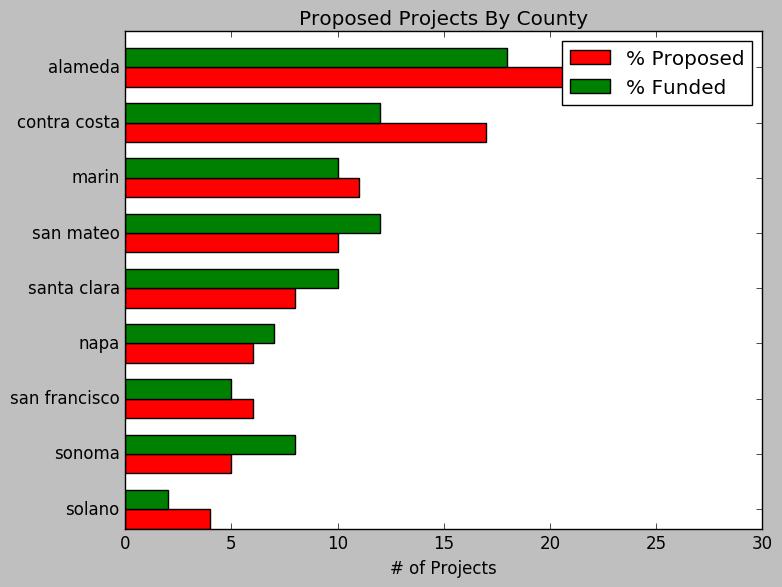

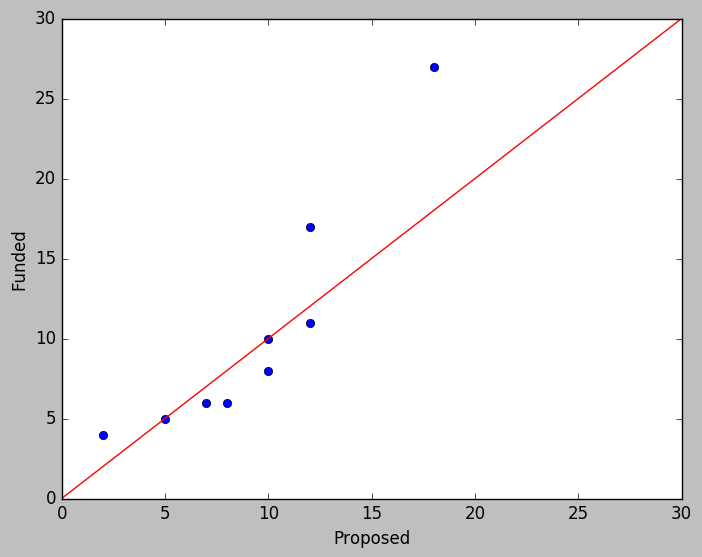

In [709]:
def plotProposedAndFundedProjects():
    proposedTupleList = sorted(countiesDict.items(), key=operator.itemgetter(1))
    fundedTupleList = sorted(fundedCountiesDict.items(), key=operator.itemgetter(1))
    counties_p = [] # proposed
#     counties_f = [] # funded

    num_projects_p = []
    num_projects_f = []
    
    total_p = sum(countiesDict.values())
    total_f = sum(fundedCountiesDict.values())
    
    for each in proposedTupleList:
        counties_p.append(each[0])
        num_projects_p.append(((each[1] * 100)/total_p))
        for proj in fundedTupleList:
            if proj[0] == each[0]:
                num_projects_f.append(((proj[1] * 100)/total_f))
                
    y_pos_p = np.arange(len(counties_p))
    width = 0.35
    fig, ax = plt.subplots()
    proposed = ax.barh(y_pos_p, num_projects_p, width, color='r')
    funded = ax.barh(y_pos_p + width, num_projects_f, width, color='g',)
    
    
    ax.set_xlabel('# of Projects')
    ax.set_title('Proposed Projects By County')
    ax.set_yticks(y_pos_p + width)
    ax.set_yticklabels(counties_p)
    ax.legend((proposed[0], funded[0]), ('% Proposed', '% Funded'))
    plt.tight_layout()
    plt.show()
    
    proposedProbPlot = np.array(num_projects_p)
    fundedProbPlot = np.array(num_projects_f)
    figure = sm.qqplot_2samples(proposedProbPlot,
                       fundedProbPlot,
                       xlabel="Proposed",
                       ylabel="Funded", 
                       line='45',
                       ax=None)
    plt.show()
    
plotProposedAndFundedProjects()


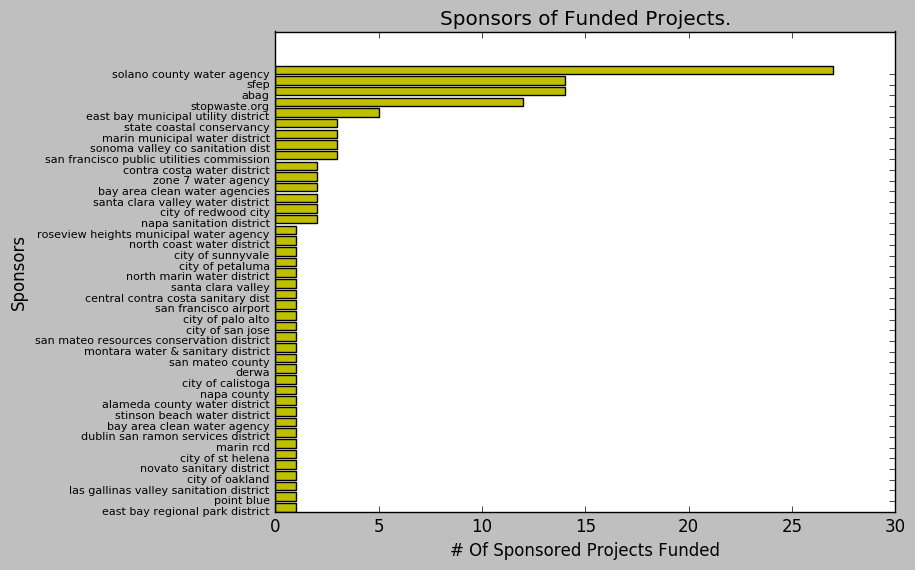

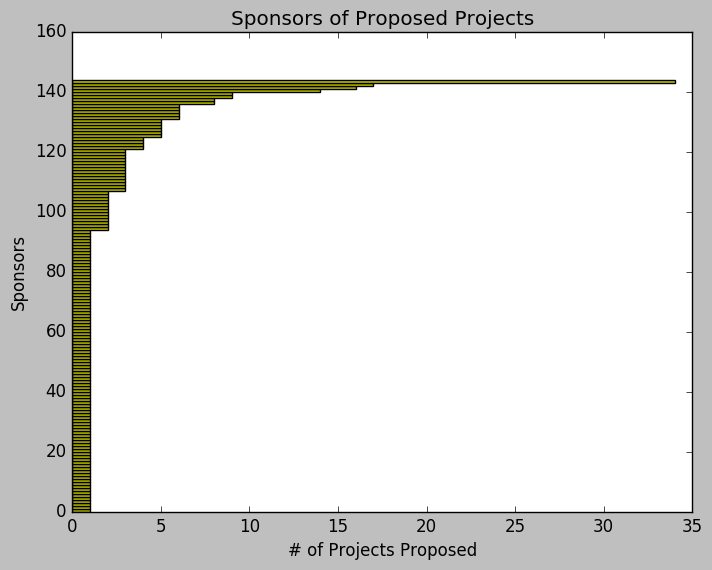

In [710]:
def plotHistogramFromTuples(tupleList,title, x_label, y_label, sz):
    x_values = []
    y_values = []
    for each in tupleList:
        y_values.append(each[0])
        x_values.append(each[1])
        
    y_axis_pos = np.arange(len(y_values))  
    plt.barh(y_axis_pos, x_values,color="y")
    if len(y_values) < 100:
        plt.yticks(y_axis_pos, y_values, fontsize=sz)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
#     plt.show()
    plt.show()
    
def visualizeProjectSponsors():
    proposedTupleList = sorted(sponsorsOfProposedProjects.items(), key=operator.itemgetter(1))
    fundedTupleList = sorted(sponsorsOfFundedProjects.items(), key=operator.itemgetter(1))
    plotHistogramFromTuples(fundedTupleList, "Sponsors of Funded Projects.", "# Of Sponsored Projects Funded",
                           "Sponsors", 8)
    plotHistogramFromTuples(proposedTupleList, "Sponsors of Proposed Projects", "# of Projects Proposed",
                           "Sponsors", 5)
    
visualizeProjectSponsors()

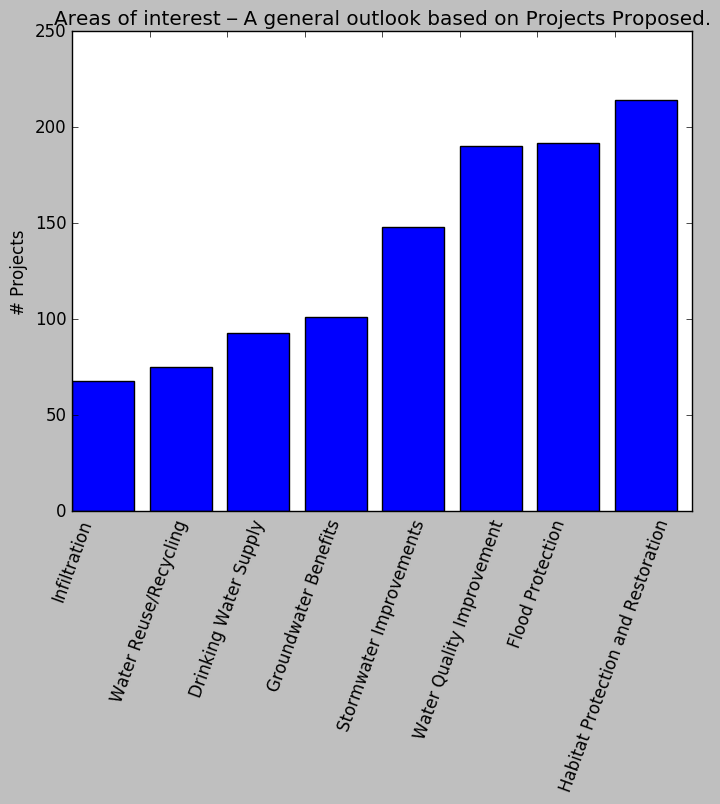

In [711]:
def plot(areasOfInterest):
    areasTuples = sorted(areasOfInterest.items(), key=operator.itemgetter(1))
    x_values = []
    y_values = []
    for each in areasTuples:
        x_values.append(each[0])
        y_values.append(each[1])
    y_pos_ticks = np.arange(len(x_values))
    plt.bar(y_pos_ticks, y_values, color="blue")
    plt.xticks(y_pos_ticks, x_values, rotation=70)
    plt.title(u"Areas of interest – A general outlook based on Projects Proposed.")
    plt.ylabel("# Projects")
    plt.show()
    
    
def visualizeAreasOfInterest():
    areasOfInterestDict = {}
    pos = 0
    for each in bitVecList:
        areasOfInterestDict[areasOfInterest[pos]] = sum(each)
        pos += 1
    plot(areasOfInterestDict)
    
visualizeAreasOfInterest()   

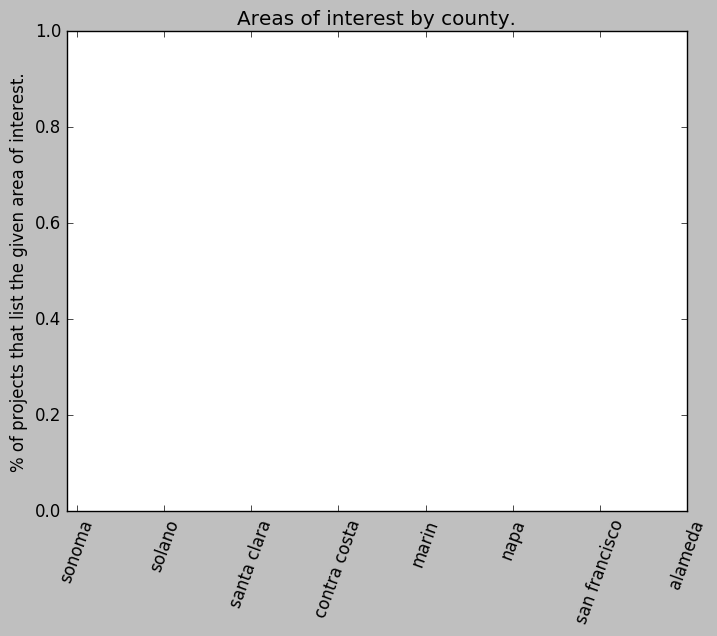

In [712]:
def visualizeAreasOfInterestByCounty():
#     print areasOfInterestByCounty
    bar_width = 0.35
    x_axis_labels = areasOfInterestByCounty.keys()
    x_locations = np.arange(len(areasOfInterest))
    plt.title("Areas of interest by county.")
    plt.ylabel("% of projects that list the given area of interest.")
    plt.xticks(x_locations + bar_width/3., tuple(x_axis_labels), rotation = 70)
    plt.show()
    
visualizeAreasOfInterestByCounty()

In [713]:
'''
The following snippets are deal with the
classification of the data that we have.

It is based on the Amazing tutorial found at
https://github.com/brandomr/document_cluster/blob/master/cluster_analysis.ipynb
'''

'\nThe following snippets are deal with the\nclassification of the data that we have.\n\nIt is based on the Amazing tutorial found at\nhttps://github.com/brandomr/document_cluster/blob/master/cluster_analysis.ipynb\n'

In [714]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
import mpld3
from __future__ import print_function
from sklearn import feature_extraction
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn.manifold import MDS

stopwords = set(nltk.corpus.stopwords.words("english"))
stemmer = SnowballStemmer("english")
clusterList = []

In [715]:
'''
Code courtesey of Brandon Rose
https://github.com/brandomr
'''
def tokenizeAndStem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

def printTopTermsPerCluster(N, referenceDF, modelDF, model, terms):
    print("Top terms per cluster:")
    print()
    #sort cluster centers by proximity to centroid
    order_centroids = model.cluster_centers_.argsort()[:, ::-1] 
    
    for i in range(N):
        print("Cluster %d words:" % i, end='')
    
        for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
            print(' %s' % referenceDF.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'),
                  end=',')
        print() #add whitespace
        print() #add whitespace
    
        print("Cluster %d titles:" % i, end='')
        num = 0
        for title in modelDF.ix[i]['title'].values.tolist():
            if(num == 5):
                break
            print(' %s,' % title, end='')
            num += 1
        print() #add whitespace
        print() #add whitespace
    print()
    print()

In [716]:
def get_TfidfMatrix_Terms_Dist(textList):
    vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenizeAndStem,
                                 ngram_range=(1,3)
                                )
    matrix = vectorizer.fit_transform(textList)
    terms = vectorizer.get_feature_names()
    distance = 1 - cosine_similarity(matrix)
    return matrix , terms, distance

In [717]:
def runKmeans(matrix, N):
    kmeans = KMeans(N)
    kmeans.fit(matrix)
    return kmeans
    
def openModel(filename):
    try:
        model = joblib.load(filename)
        return model
    except:
        print ("could not open " + str(filename))
        
def saveModel(model, name):
    try:
        joblib.dump(model, name)
    except:
        print ("Error saving model under " + name)

In [718]:
def createDataFrameFromDict(dict_, indexList):
    pandasDF = pd.DataFrame(dict_, index = indexList, # may have bug here.[indexList]
                            columns = dict_.keys())
    return pandasDF

In [719]:
'''
name is the name you want this model
to be saved as

byList is expected to be a list of
text.

structure is a dict describing the structure
of the data
'''
def classify(byList, name, structure, N):
    totalvocabStemmed = []
    totalvocabTokenized = []
#     byList = byList[0:315]
    for each in byList:
        allwordsStemmed = tokenizeAndStem(each) 
        totalvocabStemmed.extend(allwordsStemmed)
      
        allwordsTokenized = tokenize(each)
        totalvocabTokenized.extend(allwordsTokenized)
    
    frameBuilder = {
        "words" : totalvocabTokenized
    }
    vocabsDataFrame = createDataFrameFromDict(frameBuilder,
                                              totalvocabStemmed)
    
    tfidfmatrix, terms, dist = get_TfidfMatrix_Terms_Dist(byList)
    
#     kDistance = dist ##Note this precarious assignent
    
    # Should check if name already exists.
    # If it does, do not re-run the model 
    # read in the model insead.
    # openModel(name)
    kmeansModel = runKmeans(tfidfmatrix, N)
    clusters = kmeansModel.labels_.tolist()
    clusterList = copy.deepcopy(clusters)
#     print (len(clusterList))
    
    structure["clusters"] = clusters
    
    byListDataFrame = createDataFrameFromDict(structure,
                                              kmeansModel.labels_.tolist())
    printTopTermsPerCluster(N, vocabsDataFrame, byListDataFrame, kmeansModel, terms)
    return clusterList, dist

def runClassification():
    structure = {
        "title" : proposedProjectsTitles,
        "abstract" : proposedProjectsAbstracts
    }
    ls, dist = classify(essence,
             "classification by title", 
             structure, 
             5)
    return ls, dist

In [720]:
clusterList, kDistance = runClassification()

Top terms per cluster:

Cluster 0 words: upply, ue, ground, treatment, ytem, reliability,

Cluster 0 titles: cccsd-concord recycled water project , north coast county water district drought preparedness and water conservation plan , san bruno groundwater development project , north bay water reuse authority (nbwra) sub-regional project , san francisco bay nutrient reduction and recycling project ,

Cluster 1 words: creek, fih, ediment, retore, habitat, channel,

Cluster 1 titles: corte madera creek watershed: saunders fish barrier removal , lower lagunitas creek habitat restoration project , stanley enhancement and restoration project (r3-5a) , pinole creek fish passage improvements project at i-80 culverts , rodeo creek stabilization near christie road rodeo (#16) ,

Cluster 2 words: flooding, creek, retore, habitat, protection, channel,

Cluster 2 titles: napa river arundo removal lodi lane to zinfandel lane , the students and teachers restoring a watershed (straw) program , bay area

In [724]:
def MDScale():
    MDS()
    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

    pos = mds.fit_transform(kDistance)  # shape (n_components, n_samples)

    xs, ys = pos[:, 0], pos[:, 1]
    return xs, ys

In [729]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
#set up cluster names using a dict
cluster_names = {
                0: 'water conservation efforts, water recycling, drought preparedness', 
                1: 'creek habitat restoration, fish', 
                2: 'wetland restoration', 
                3: 'stromwater tratment', 
                4: 'flooding, natural habitat protection'
}

In [730]:
def visualizeClusters():
    #set up colors per clusters using a dict
    cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
    #set up cluster names using a dict
    cluster_names = {0: 'water conservation efforts, water recycling, drought preparedness', 
                     1: 'creek habitat restoration, fish', 
                     2: 'wetland restoration', 
                     3: 'stromwater tratment', 
                     4: 'flooding, natural habitat protection'}
    
    #some ipython magic to show the matplotlib plots inline
    %matplotlib inline 

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    xs, ys = MDScale()
    
#     print(len(clusterList))
#     print(len(xs))
#     print(len(proposedProjectsTitles))
#     print (len(proposedProjectsTitles[0:315]))
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusterList, title=proposedProjectsTitles))
    
    #group by cluster
    groups = df.groupby('label')


    # set up plot
    fig, ax = plt.subplots(figsize=(17, 9)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
                label=cluster_names[name], color=cluster_colors[name], 
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='off')

    ax.legend(numpoints=1)  #show legend with only 1 point

    #add label in x,y position with the label as the film title
    for i in range(len(df)):
        ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  



    plt.show() #show the plot

    #uncomment the below to save the plot if need be
    #plt.savefig('clusters_small_noaxes.png', dpi=200)
    

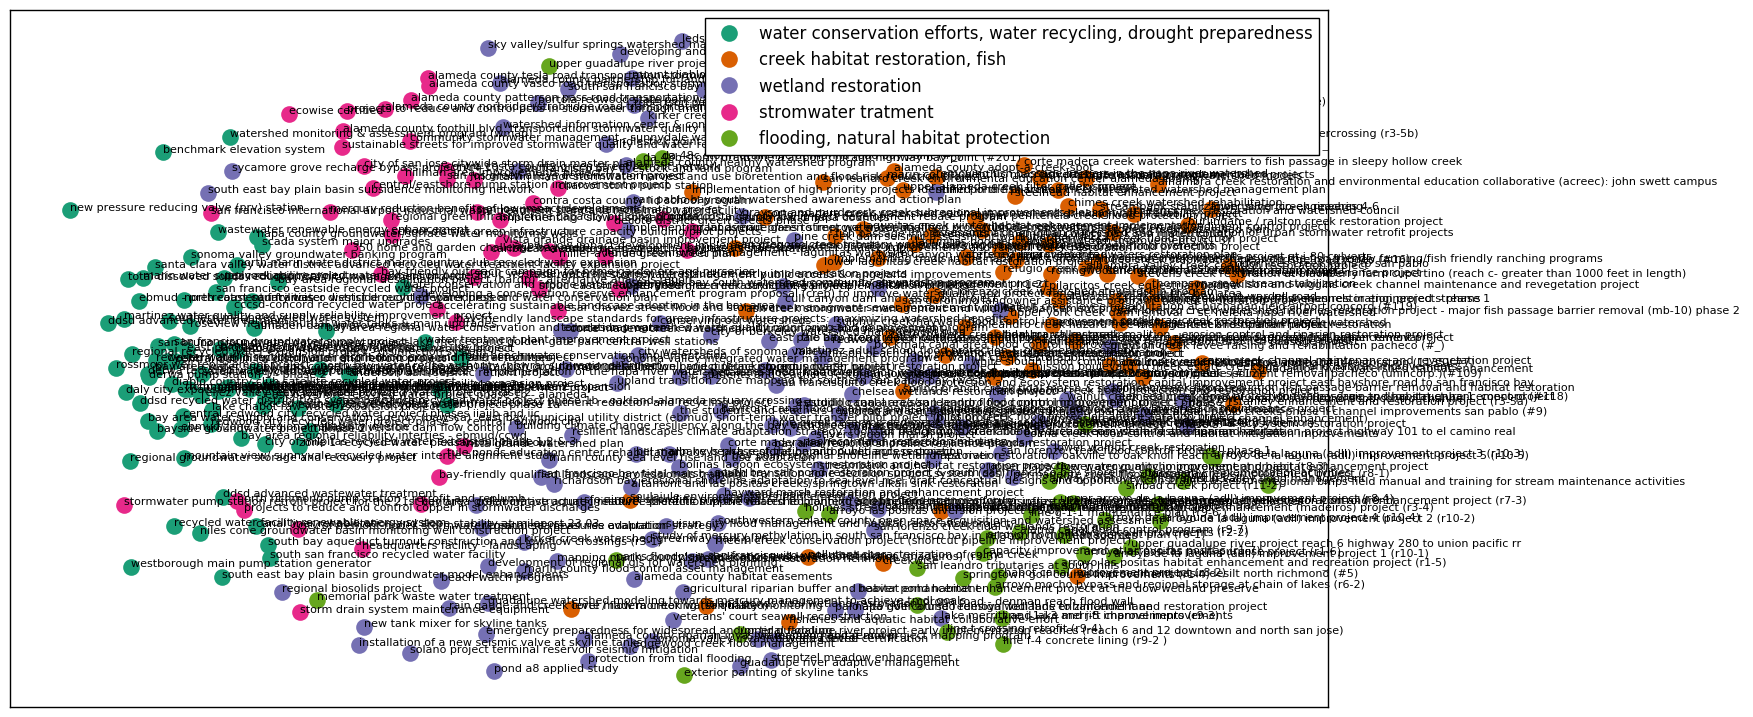

In [731]:
visualizeClusters()

In [732]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [735]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
xs, ys = MDScale()
df = pd.DataFrame(dict(x=xs, y=ys, label=clusterList, title=proposedProjectsTitles))

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)